In [1]:
import pyodbc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.anomaly import *

In [2]:
## Conexion al DWH
cnxn = pyodbc.connect(
    driver='{SQL Server}',
    server='192.168.100.58',
    uid='bilectura',
    pwd='D1sp@p3l3s')
cursor = cnxn.cursor()
#cnxn.close()

In [3]:
fecha_inicio = "'2021-01-01'"
fecha_final = "'2022-12-31'"

In [4]:
codigo_SQL = f"SELECT A.VTAANO AS 'Ano', A.VTAMES AS 'Mes', A.DSTCOD AS 'Codigo distrito', A.VTAZNA AS 'Codigo zona', A.VTANIT AS 'Nit cliente', C.NITNOM AS 'Nombre cliente', A.VTAPRDCOD AS 'Codigo producto', B.TPOCOD AS 'Codigo tipo', B.LNACOD AS 'Codigo linea', B.GRPCOD AS 'Codigo grupo', B.CLDCOD AS 'Codigo calidad', SUM(A.VTAVLRVTA) AS 'Ventas', SUM(A.VTACST) AS 'Costo' FROM V_VTA_VTAHEC A LEFT JOIN DIM_PRODUCTOS B ON A.PRMCOD = B.PRMCOD AND A.VTAPRDCOD = B.PRDCOD LEFT JOIN DIM_NITS C ON A.VTANIT = C.NITNIT WHERE A.PRMCOD = 1 AND A.DSTCOD != 30 AND A.VTAZNA < 96 AND A.VTAFCH BETWEEN {fecha_inicio} AND {fecha_final} AND  B.TPOCOD NOT IN (990,999) GROUP BY A.VTAANO, A.VTAMES, A.DSTCOD, A.VTAZNA, A.VTANIT, C.NITNOM, A.VTAPRDCOD, B.TPOCOD, B.LNACOD, B.GRPCOD, B.CLDCOD"

In [ ]:
codigo_SQL

In [5]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [6]:
maestra_gerencias = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Anomaly detection/Maestra_gerencias.csv', delimiter= ";")

In [7]:
df_merged = pd.merge(df, maestra_gerencias, on= "Codigo producto")

In [8]:
df_gb = df_merged.groupby(["Ano", "Mes", "Codigo distrito", "Codigo zona", "Nit cliente", "Nombre cliente", "Codigo tipo",
                            "Codigo linea", "Codigo grupo", "Codigo calidad", "Gerente", "Línea CAM"]).agg({"Ventas": np.sum,
                                                                                                            "Costo": np.sum})
df_gb = df_gb.reset_index(col_level= 1)
df_gb["Codigo distrito-zona"] = df_gb["Codigo distrito"].astype(str) + "-" + df_gb["Codigo zona"].astype(str)
df_gb["Margen"] = df_gb["Ventas"] - df_gb["Costo"]
df_gb["Ventas"] = df_gb["Ventas"].astype(int)
df_gb["Margen"] = df_gb["Margen"].astype(int)

In [9]:
df_gb.head()

,Ano,Mes,Codigo distrito,Codigo zona,Nit cliente,Nombre cliente,Codigo tipo,Codigo linea,Codigo grupo,Codigo calidad,Gerente,Línea CAM,Ventas,Costo,Codigo distrito-zona,Margen
0,2021,1,10,1,52798044,ALVAREZ GINA MILENA,235,103,180,334,Elementos de Protección Personal,Protección personal,284227,224390,10-1,59837
1,2021,1,10,1,79571067,GARCES HEREDIA MAURICIO,180,160,59,25,Comunicación visual,Tintas,832743,669435,10-1,163308
2,2021,1,10,1,79743894,RODRIGUEZ YOVANNI,180,160,59,25,Comunicación visual,Tintas,278095,222240,10-1,55855
3,2021,1,10,1,800032769,GAMACOLOR EDITORIAL S.A.S,105,1,1,50,Cartulina,Propal,16182936,14611847,10-1,1571089
4,2021,1,10,1,800032769,GAMACOLOR EDITORIAL S.A.S,160,168,203,73,Flexografía,Insumos Flexografía,322407,291087,10-1,31320


In [ ]:
df_gb.corr()*100

<AxesSubplot:>

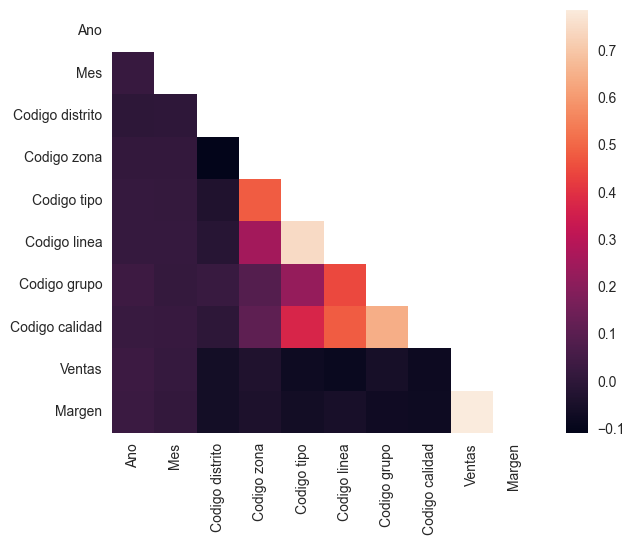

In [24]:
corr_matrix = df_gb.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask= mask, square= True)

In [11]:
list_dst_znas = (df_gb["Codigo distrito"].astype(str) + "-" + df_gb["Codigo zona"].astype(str)).unique()
categorical_columns = ["Ano", "Mes", "Codigo distrito", "Codigo zona", "Nit cliente","Nombre cliente", "Codigo tipo",
                        "Codigo linea", "Codigo grupo", "Codigo calidad", "Gerente", "Línea CAM", "Codigo distrito-zona"]
ignore_columns = ["Ano", "Mes", "Codigo grupo", "Codigo calidad", "Codigo distrito-zona"]
numerical_columns = ["Ventas", "Costo", "Margen"]

In [23]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [22]:
consolidado = pd.DataFrame([])
for n, dtozna in enumerate(list_dst_znas):
    print(f"Procesando {n+1} de {len(list_dst_znas)+1}. {(n+1) / (len(list_dst_znas)+1):.1%}")
    #Creacion del subdataset
    df_dto = df_gb[df_gb["Codigo distrito-zona"] == dtozna]
    
    #Setup modelo
    exp_ano101 = setup(df_dto, 
                        session_id = 42,
                        silent=True,
                        categorical_features = categorical_columns,
                        numeric_features = numerical_columns,
                        ignore_features = ignore_columns,
                        normalize = True,
                        normalize_method = 'robust',
                        verbose = False)
    
    #Modelo iforest
    iforest = create_model('iforest')
    iforest_results = assign_model(iforest)
    resultado_iforest = iforest_results.loc[(iforest_results["Anomaly"] == 1) & 
                                            (iforest_results["Anomaly_Score"] >= 0.02) &
                                            ((iforest_results["Ventas"] >= 2000000) | (iforest_results["Margen"] < 0)) &
                                            (iforest_results["Ano"] == 2022) & 
                                            (iforest_results["Mes"] == 11)
                                            ]

    #Append a una base general
    consolidado = consolidado.append(resultado_iforest)

#Descarga de la base general
consolidado.index = pd.RangeIndex(len(consolidado.index))
consolidado.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Anomaly detection/Anomalies_iforest/Anomalies nov 25-1-23.csv",
                    encoding= 'utf-8', index= False, sep= ";", decimal = ",")

print("Proceso completo 100%")

Proceso completo 100%


In [ ]:
consolidado = pd.DataFrame([])
for n, dtozna in enumerate(list_dst_znas):
    print(f"Procesando {n+1} de {len(list_dst_znas)+1}. {(n+1) / (len(list_dst_znas)+1):.1%}")
    #Creacion del subdataset
    df_dto = df_gb[df_gb["Codigo distrito-zona"] == dtozna]
    
    #Setup modelo
    exp_ano101 = setup(df_dto, 
                        session_id = 42,
                        silent=True,
                        categorical_features = categorical_columns,
                        numeric_features = numerical_columns,
                        ignore_features = ignore_columns,
                        normalize = True,
                        normalize_method = 'robust',
                        verbose = False)
    
    #Modelo iforest
    iforest = create_model('iforest')
    iforest_results = assign_model(iforest)
    resultado_iforest = iforest_results.loc[(iforest_results["Anomaly"] == 1) & 
                                            (iforest_results["Anomaly_Score"] >= 0.04) &
                                            ((iforest_results["Ventas"] >= 2000000) | (iforest_results["Margen"] < 0)) &
                                            (iforest_results["Ano"] == 2022) & 
                                            (iforest_results["Mes"] == 12)
                                            ]

    #Append a una base general
    consolidado = consolidado.append(resultado_iforest)

#Descarga de la base general
consolidado.index = pd.RangeIndex(len(consolidado.index))
consolidado.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Anomaly detection/Anomalies_iforest/Anomalies dic 25-1-23.csv",
                    encoding= 'utf-8', index= False, sep= ";", decimal = ",")

print("Proceso completo 100%")